Once obtained oBD and mBD from SiNN, it's possible to determine the porosity as, following the work of [Robinson et al., 2022](https://doi.org/10.1038/s41598-022-11099-7):


$$
\varphi
= 1 -
\left[
\left(
\frac{SOM}{oPD} + \frac{1 - SOM}{mPD}
\right)
\div
\left(
\frac{SOM}{oBD} + \frac{1 - SOM}{mBD}
\right)
\right]
$$

where oBD and mBD are bulk density of the organic and mineral constituent of soil, while mPD and oPD are the corresponding particle density. Here we assume a constant number for oPD and mPD, adopting the one used by [Robinson et al., 2022](https://doi.org/10.1038/s41598-022-11099-7), mPD 2.7 g cm−3 and oPD 1.4 g cm−3，



In [17]:
import pandas as pd
import numpy as np
version = 'v20251209'
df = pd.read_parquet(f'./eval/all_cv.pred_with.lc_{version}.pq')
hbd = df[['row_id', 'time', 'lat', 'lon', 'id', 'nuts0', 'maxdiff', 'bd', 'clay',
       'sand', 'silt', 'cf', 'ocd', 'soc', 'SOCconc', 'CF', 'BD', 'SOCdensity',
       'ndvi', 'ndwi', 'lst_night', 'lst_day', 'precipitation', 'peat',
       'SiNN_BD', 'SiNN_SOCconc', 'SiNN_CF', 'SiNN_SOCdensity', 'pred_oBD',
       'pred_mBD', 'LC1', 'LC_group']].copy()
print(hbd.shape)

# calculate porocity
hbd["som"] = hbd["soc"] * 1.724/1000
hbd["som"] = np.minimum(hbd["som"], 1)

hbd["isom"] = 1 - hbd["som"]

mPD = 2.7
oPD = 1.4

hbd["poro"] = 1 - (
    (hbd["som"] / oPD + hbd["isom"] / mPD) /
    (hbd["som"] / hbd["pred_oBD"] + hbd["isom"] / hbd["pred_mBD"])
)

(56117, 32)


In [25]:
stats = (
    hbd
    .dropna(subset=["LC_group", "poro"])
    .groupby("LC_group")["poro"]
    .agg(["count", "mean", "std", "min", "median", "max"])
)

print(stats)


            count      mean       std       min    median       max
LC_group                                                           
artificial    177  0.609641  0.069946  0.470125  0.592804  0.902966
bareland     1513  0.568565  0.048879  0.426671  0.563735  0.872562
cropland    25150  0.561579  0.047061  0.408727  0.556370  0.892750
grassland   12779  0.615703  0.064542  0.418813  0.608243  0.937388
shrubland    1768  0.651156  0.069968  0.475980  0.642168  0.936486
wetland       154  0.775127  0.146949  0.445511  0.846390  0.942256
woodland    14428  0.682233  0.088292  0.448421  0.670274  0.951836


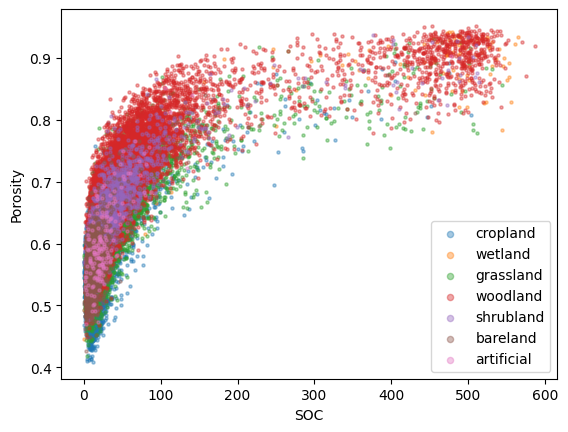

In [22]:
import matplotlib.pyplot as plt

for lc in hbd["LC_group"].dropna().unique():
    mask = hbd["LC_group"] == lc
    plt.scatter(
        hbd.loc[mask, "soc"],
        hbd.loc[mask, "poro"],
        s=5,
        alpha=0.4,
        label=lc
    )

plt.xlabel("SOC")
plt.ylabel("Porosity")
plt.legend(markerscale=2)
plt.show()


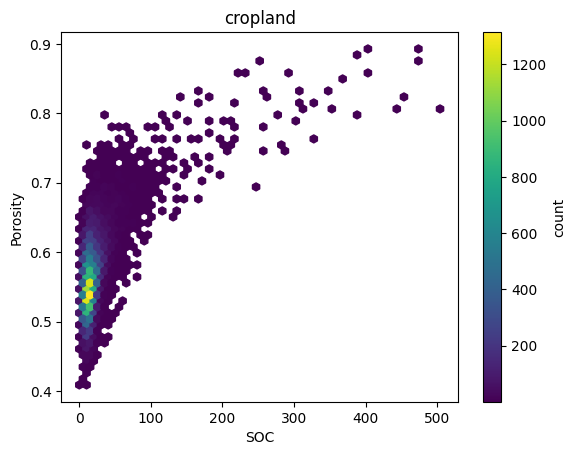

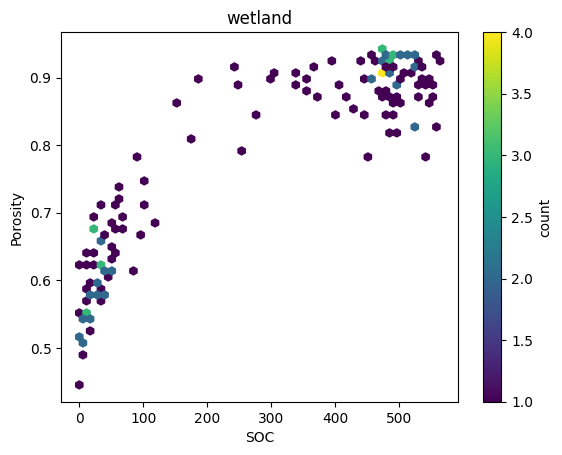

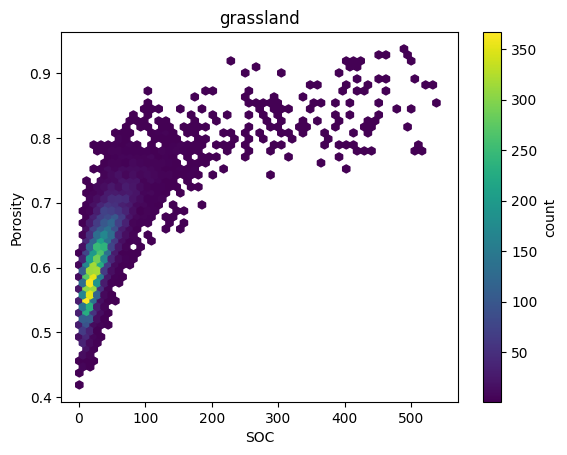

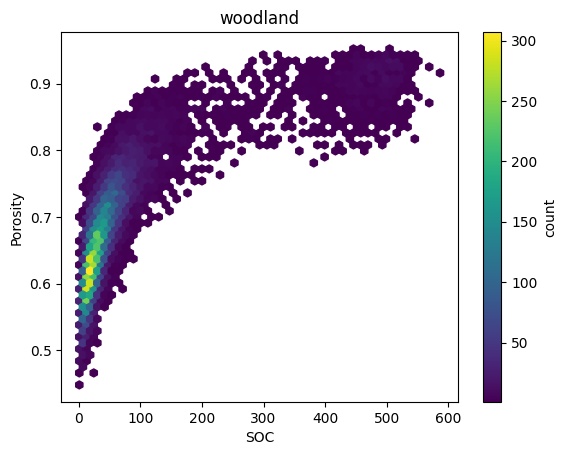

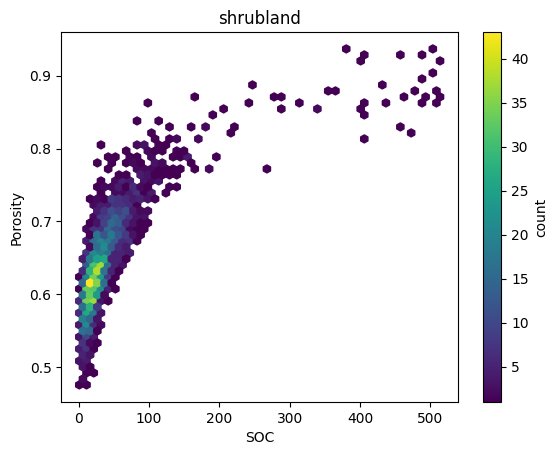

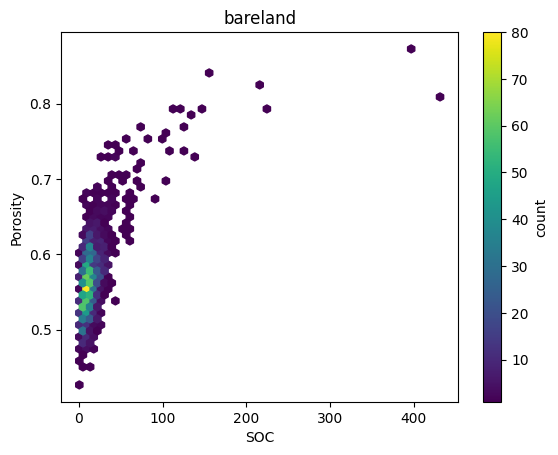

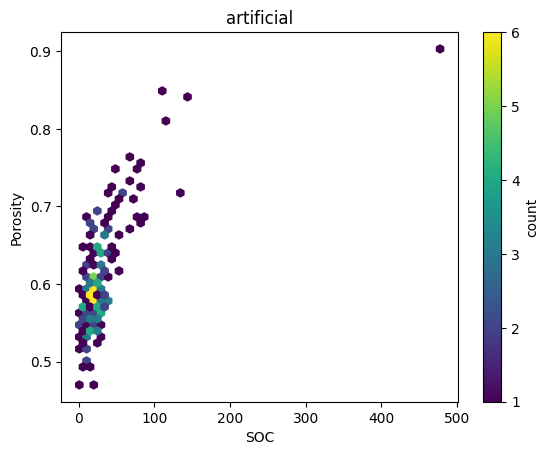

In [24]:

for lc in hbd["LC_group"].dropna().unique():
    mask = hbd["LC_group"] == lc

    plt.figure()
    plt.hexbin(
        hbd.loc[mask, "soc"],
        hbd.loc[mask, "poro"],
        gridsize=50,
        mincnt=1
    )
    plt.xlabel("SOC")
    plt.ylabel("Porosity")
    plt.title(lc)
    plt.colorbar(label="count")
    plt.show()
